<a href="https://colab.research.google.com/github/Dltmd202/DeepLearningStudy/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
from scipy.signal import convolve, correlate
import tensorflow as tf
from sklearn.model_selection import train_test_split

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2,
                                                  random_state=42)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_train = x_train / 255
x_val = x_val / 255

In [37]:
class ConvolutionNetwork:

  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
    self.n_kernels = n_kernels
    self.kernel_size = 3
    self.optimizer = None
    self.conv_w = None
    self.conv_b = None
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
  
  def forpass(self, x):
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
    r_out = tf.nn.relu(c_out)
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
    f_out = tf.reshape(p_out, [x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(a1, self.w2) + self.b2
    return z2
  
  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
    n_features =14 * 14 * self.n_kernels
    self.w1 = tf.Variable(g((n_features, self.units)))
    self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
    self.w2 = tf.Variable(g((self.units, n_classes)))
    self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)
  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape, y.shape[1])
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    for i in range(epochs):
      print('eopoch', i, end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end='')
        self.training(x_batch, y_batch)
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print()
      self.losses.append(np.mean(batch_losses))
      self.val_losses.append(self.get_loss(x_val, y_val))
  
  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]
  
  def training(self, x, y):
    m = len(x)
    with tf.GradientTape() as tape:
      z = self.forpass(x)
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)
    
    weight_list = [self.conv_w, self.conv_b,
                   self.w1, self.b1, self.w2, self.b2]
    grads = tape.gradient(loss, weight_list)
    self.optimizer.apply_gradients(zip(grads, weight_list))
  
  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z.numpy(), axis=1)
  
  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))
  
  def get_loss(self, x, y):
    z = self.forpass(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()

In [40]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

eopoch 0 .......................................................................................................................................................................................................................................................................................................................................................................................
eopoch 1 .......................................................................................................................................................................................................................................................................................................................................................................................
eopoch 2 .............................................................................................................................................................................................................................

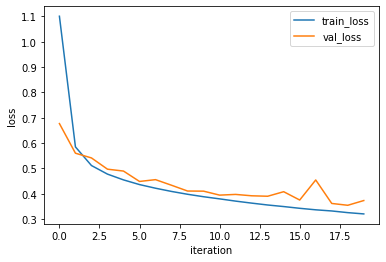

In [41]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [42]:
cn.score(x_val, y_val_encoded)

0.8665